## Elastic Net
Jonathan Cruz y Germán Villar

Bibliografía:

[Zou & Hastie (2003) - "Elastic Net"](https://web.stanford.edu/~hastie/Papers/elasticnet.pdf)

[Hastie, Tibshiranie & Friedman (2009) - "Elements of Statistical Learning"](http://statweb.stanford.edu/~tibs/ElemStatLearn/)

[Lobert, Eis & Costina (2010) - "Exploiting Covariate Similarity in Sparse Regression via the
Pairwise Elastic Net"](http://machinelearning.wustl.edu/mlpapers/paper_files/AISTATS2010_LorbertEKBR10.pdf)


Elastic Net es un método de regularización y selección de variables creado a partir de Ridge Regression y Lasso. 
  * Resuelve el problema de sobrediscriminación que realiza Lasso mediante el efecto de agrupamiento de Ridge. 
  * Por lo anterior, es un método útil para el caso $p>>n$

## Naive Elastic Net
Suponemos un conjunto de datos con $n$ observaciones con $p$ predictores. Sea $y= (y_{1},...,y_{n})^{T}$ (las respuestas) y $X = \{x_{1},\cdots, x_{p}\}$ la matriz del modelo, donde $x_{j}=(x_{1j},...,x_{nj})^{T}$, $ j=1,...,p$ son los predictores. Después de centrar y estandarizar los predictores. 

Para algún no-negativo $\lambda_{1}$ y $\lambda_{2}$, definimos el criterio de naive elastic net:
$$ L (\lambda_{1}, \lambda_{2}, \beta)=|y-X\beta|^{2} + \lambda_{2}|\beta|^{2} + \lambda_{1}|\beta|_{1}$$
Donde: $$|\beta|^{2} = \sum_{j=1}^{p} \beta_{j}^{2} $$ y $$ |\beta|_{1}= \sum_{j=1}^{p} |\beta_{j}|  $$
Por lo tanto, el estimador de "naive elastic net" es:
$$ \hat{\beta} = {argmin}_{\beta} L(\lambda_{1}, \lambda_{2}, \beta) $$

El método anterior se puede enter como un método de OLS penalizador. 

Por lo tal, sea  $\alpha= \frac {\lambda_{2}} {\lambda_{1} + \lambda_{2}}$, entonces podemos replantear el problema de optimización por: 

$$ \hat{\beta} = {argmin}_{\beta} |Y-X\beta|^{2} $$
S.t. $(1-\alpha)|\beta|_{1} + \alpha |\beta|^{2} \leq t $ para algún $t$.

### Geometría de la penalización de Elastic Net

Podemos llamar a $(1-\alpha)|\beta|_{1} + \alpha |\beta|^{2} \leq t $ la penalización de elastic net, la cual es una combinación convexa de Lasso y Ridge penalty. Cuando $\alpha = 1$ the naive elastic net es una regresión simple de ridge. 

Asumimos $\alpha < 1$, $\forall \alpha \in [0,1)$, cuando $\alpha=0$ la función no tiene primera derivada y $\forall \alpha > 0$ es una función estrictamente convexa, es decir, Naive Elastic Net es una combinación lineal de Ridge y Lasso.  



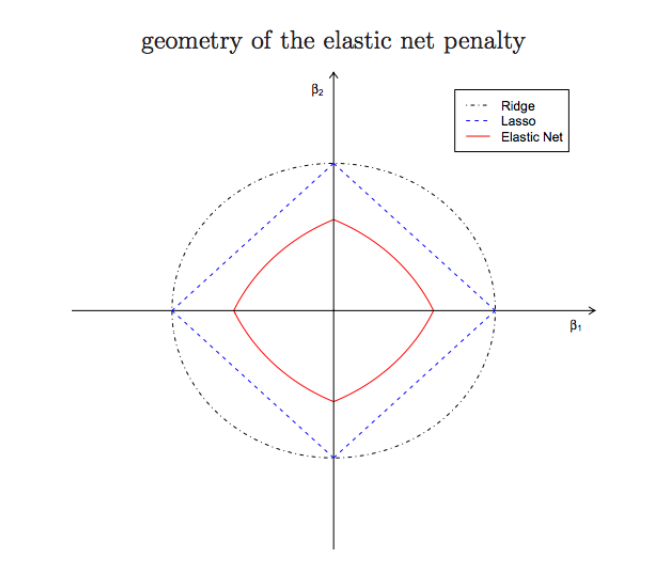

In [3]:
from IPython.display import Image
Image(filename='Geometria.png')

## Corrección por sesgo (Elastic Net)
El método de Elastic Net hace simultáneamente la selección de varibles (reduciendo o quitando las menos importantes), además de que selecciona los grupos de variables seleccionadas.

$$ \hat{\beta}^{*} = {argmin_{\beta}} |y^{*} - X^{*} \beta^{*}| ^{2}+ \frac {\lambda_{1}} {\sqrt{1+\lambda_{2}}} |\beta^{*}|_{1}$$
$$ \hat{\beta}_{e n}=\sqrt{1+\lambda_{2}}\hat{\beta^{*}} $$ 
$$ \hat{\beta}_{n e n}=\frac{1}{\sqrt{1+\lambda_{2}}}\hat{\beta^{*}} $$ 
$$ \hat{\beta}_{e n} = (1+\lambda_{2}) \hat{\beta}_{n e n}$$ 

El método de Elastic Net es una reescala del método de Naive Elastic Net, en donde se conservan las propiedades de este último con la única diferencia que Elastic Net corrije el "double shrinkage" originado por NET y, así, reduce el sesgo. 




La justificación principal para $(1+\lambda_{2})$ la reescala viene de la descomposición del operador de Ridge. Donde los predictores $X$ están estandarizados, tenemos:

$$ X'X= 
\begin{bmatrix}
1 & \rho_{12} & \rho_{13}&\cdots & \rho_{1p}           \\[0.3em]
   & 1 & \rho_{23} & \cdots& \rho_{2p}                   \\[0.3em]
       &    & \ddots &    &   \vdots        \\[0.3em]
      &    &  &  1  &   \rho_{p-1,p}       \\[0.3em]
     & &   &         &      1
     \end{bmatrix} $$
     
$$ \hat{\beta_{Ridge}}= \mathbf{R} \mathbf{y} $$
$$ R= \frac {1}{1+\lambda_{2}}R^{*}=\frac {1}{1+\lambda_{2}}
\begin{bmatrix}
1 & \frac {\rho_{12}}{1+\lambda_{2}} & \frac {\rho_{13}}{1+\lambda_{2}}&\cdots & \frac {\rho_{1p}}{1+\lambda_{2}}    \\[0.3em]
   & 1 & \frac {\rho_{23}}{1+\lambda_{2}} & \cdots& \frac {\rho_{2p} }{1+\lambda_{2}}                  \\[0.3em]
       &    & \ddots &    &   \vdots        \\[0.3em]
      &    &  &  1  &   \frac {\rho_{p-1,p}}{1+\lambda_{2}}       \\[0.3em]
     & &   &         &      1
     \end{bmatrix}^{-1}
X^{T}$$